In [14]:

import math
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)

from numpy import genfromtxt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
DataSet=genfromtxt('C:/Users/addatta/Documents/CNTK learnings/DataSets/S11.dat',delimiter=',')
DataSet.shape

(5188, 3968)

In [5]:
Label=genfromtxt('C:/Users/addatta/Documents/CNTK learnings/DataSets/Label.dat',delimiter=',')
Label.shape

(5188,)

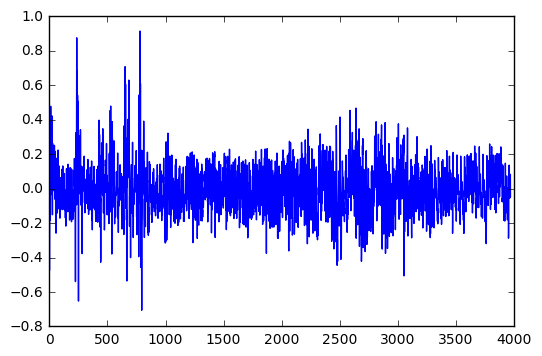

In [21]:
#plotting 1 row to show data for reading 1
plt.plot(DataSet[0], label=Label[0])

In [7]:
#Transposing the label 
LabelT=np.reshape(Label,(5188,1)) #reshaping for onehotencoder
LabelT.shape

(5188, 1)

In [10]:
#onehotencoder - it makes it to binary depending on the number of classes
enc = preprocessing.OneHotEncoder() 
enc.fit(LabelT)
LabelTEncoded=enc.transform(LabelT).toarray()
LabelTEncoded.shape

(5188, 6)

In [11]:
#Reshaping DataSet to 3d array
DataSet3d=np.reshape(DataSet,(5188,32,124))
DataSet3d.shape

(5188, 32, 124)

In [16]:
#Splitting into testing, training set
train_DS, test_DS, train_Label, test_Label=train_test_split(DataSet3d, LabelTEncoded, test_size=0.3)

In [20]:
train_Label.shape

(3631, 6)

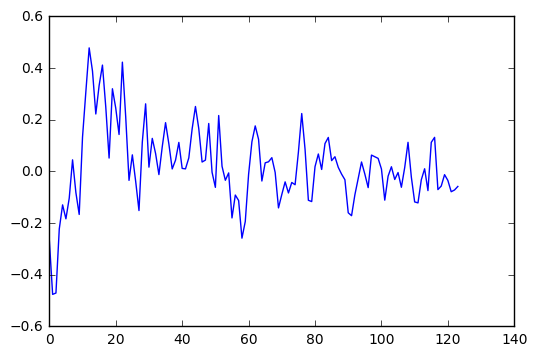

In [22]:
plt.plot(DataSet3d[0][0], label=Label[0])

In [30]:
#Setting up the LSTM network
H_DIMS=15    #Number of hidden dimensions
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(H_DIMS))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = C.layers.Dense(1)(m)
        return m

In [34]:
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
isFast = True
EPOCHS = 100 if isFast else 2000

TIMESTEPS = 14
# process batches of 10 days
BATCH_SIZE = TIMESTEPS * 10


def next_batch(x, y, ds):
    """get the next batch for training"""

    def as_batch(data, start, count):
        return data[start:start + count]

    for i in range(0, len(x[ds]), BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)


In [36]:
#Training

#input sequence
x = C.sequence.input_variable(32)


#Create the Model
z = create_model(x)

#expected output ***THIS IS WHAT I AM NOT UNDERSTANDING - what should the output be?****

l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.005
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss function
loss = C.squared_error(z, l)

# use squared error to determine error for now
error = C.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant)
trainer = C.Trainer(z, (loss, error), [learner])

In [37]:
# training
loss_summary = []

start = time.time()
for epoch in range(0, EPOCHS):
    for x_batch, l_batch in next_batch(train_DS, train_Label, "train"):
        trainer.train_minibatch({x: x_batch, l: l_batch})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("Training took {:.1f} sec".format(time.time() - start))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices